# Comparing Networks

In this notebook, we want to compare different network to each other.
This one contains

- Untrained Model
- Trained Model
- Trained Model (**Simple Gradient Ascent Unlearning**)*$^1$

There will be a notebook for every approx. MU algorithm

*$^1$ Simple Gradient Ascent: For every sample that we want to unlearn, we will take a step "up the loss function" in the training loop.

In [25]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np
# from helper import get_model TODO Muss überarbeitet werden
from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

ALLREADY_TRAINED = True

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

139

In [26]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

In [27]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    untrained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    untrained_showcase_all = ConvNet()
name = str(untrained_showcase_all)
untrained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
        weights_only=True
        )
    )
untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model


In [28]:
if USED_DATASET in ["mnist", "fashion_mnist"]:
    trained_showcase_all= TwoLayerPerceptron()
if USED_DATASET in ["cmnist"]:
    trained_showcase_all = ConvNet()
name = str(trained_showcase_all)
trained_showcase_all.load_state_dict(
    torch.load(
        f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase",
        weights_only=True
        )
    )

<All keys matched successfully>

In [29]:
trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Simple Gradient Ascent Model


In [30]:
from unlearning import unlearn_n_models, SimpleGradientAscent
from training import save_model
from torch.utils.data import DataLoader

In [31]:
unlearned_dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

In [32]:
# Train a single model first
if not ALLREADY_TRAINED:
    sga = SimpleGradientAscent(
        model=trained_showcase_all,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
    )
    mu_showcase = sga.unlearn()
    save_model(mu_showcase, name="mu_showcase", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc", logs=False)
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        mu_showcase= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        mu_showcase= ConvNet()
    name = str(mu_showcase)
    mu_showcase.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}{name}_mu_showcase",
            weights_only=True
            )
        )

In [33]:

if not ALLREADY_TRAINED:
    mu_ms = unlearn_n_models(
        models=trained_ms,
        unlearned_data=unlearned_dataloader,
        dataset_name=USED_DATASET,
        which_unlearning="SimpleGradientAscent",
        logs=True,
    )
    for i, model in mu_ms.items():
        save_model(model=model, name=f"{i}_mu", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble", logs=False)

else:
    mu_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}SimpleGradAsc{os.sep}test_ensemble")

___

## Metrics

In [34]:
from metrics import calc_accuracy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [35]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [36]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.640473065428022

In [37]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, mu_ms, metric="l2_norm")
a12

27.639720968370224

#### Trained to ...

In [38]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, mu_ms, metric="l2_norm")
a21

27.50620808322914

#### Exact to ...

In [14]:
# see above

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [39]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [40]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.8423793366334617

In [41]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.6477487343273385

#### Trained to...

In [42]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.1184463152201227

In [43]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=mu_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.32392754319665157

#### MU to...

In [44]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.856457520196382

In [45]:
calc_mutlimodel_metric_average(
    modeltype1=mu_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.42804418479891276

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [46]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average accuracy for D_gesamt: 0.8222 - Standard Deviation for D_gesamt: 0.0012


Average accuracy for D_remain: 0.8332 - Standard Deviation for D_remain: 0.0012


Average accuracy for 0: 0.9322 - Standard Deviation for 0: 0.0041


Average accuracy for 1: 0.9537 - Standard Deviation for 1: 0.0027


Average accuracy for 2: 0.8497 - Standard Deviation for 2: 0.0080


Average accuracy for 3: 0.8313 - Standard Deviation for 3: 0.0069


Average accuracy for 4: 0.8968 - Standard Deviation for 4: 0.0097


Average accuracy for 5: 0.7754 - Standard Deviation for 5: 0.0113


Average accuracy for 6: 0.9350 - Standard Deviation for 6: 0.0036


Average accuracy for 8: 0.8330 - Standard Deviation for 8: 0.0083


Average accuracy for 9: 0.8543 - Standard Deviation for 9: 0.0100


Average accuracy for 7_all: 0.3641 - Standard Deviation for 7_all: 0.0100


Average accuracy for 7_remain: 0.4131 - Standard Deviation for 7_remain: 0.0111


Average accuracy for 7_erased: 0.0522 - Standard Deviation for 7_erased: 0.0046
plotting...


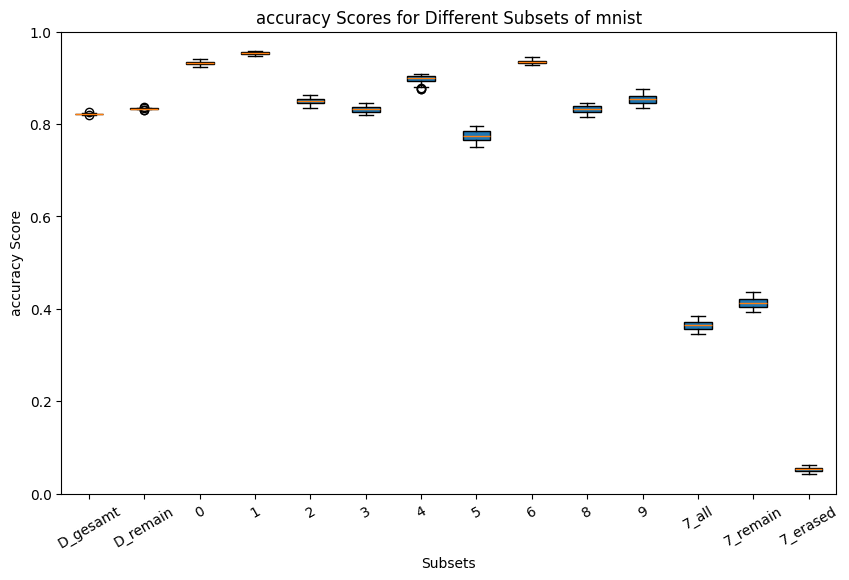

In [ ]:
# can take like 80minutes
accs["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Accuracy", logs=True)

#### Losses

In [48]:
losses = {}

Starts evaluation for 'mnist'...


Average loss for D_gesamt: 0.0860 - Standard Deviation for D_gesamt: 0.0004


Average loss for D_remain: 0.0817 - Standard Deviation for D_remain: 0.0004


Average loss for 0: 0.0467 - Standard Deviation for 0: 0.0017


Average loss for 1: 0.0479 - Standard Deviation for 1: 0.0015


Average loss for 2: 0.0701 - Standard Deviation for 2: 0.0027


Average loss for 3: 0.0845 - Standard Deviation for 3: 0.0025


Average loss for 4: 0.0703 - Standard Deviation for 4: 0.0025


Average loss for 5: 0.1095 - Standard Deviation for 5: 0.0026


Average loss for 6: 0.0449 - Standard Deviation for 6: 0.0017


Average loss for 8: 0.0891 - Standard Deviation for 8: 0.0025


Average loss for 9: 0.0905 - Standard Deviation for 9: 0.0029


Average loss for 7_all: 0.2072 - Standard Deviation for 7_all: 0.0020


Average loss for 7_remain: 0.1788 - Standard Deviation for 7_remain: 0.0020


Average loss for 7_erased: 0.3880 - Standard Deviation for 7_erased: 0.0042
plotting...


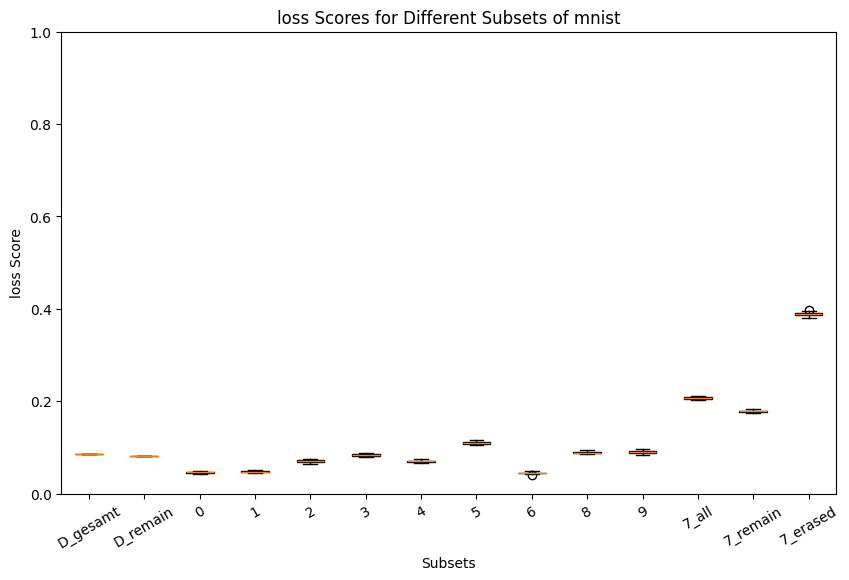

In [ ]:
losses["mu_ms"] = boxplotting_multimodel_eval(mu_ms, dataset_name=USED_DATASET, evaluation="Loss", logs=True)